In [15]:
import torch
import torch.nn as nn
import torchvision.datasets
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Hyperparameters and constants
BATCH_SIZE = 64
NUM_TRAIN = 49000
EPOCHS = 10

PRINT_EVERY = 100

SAVE_MODEL = True

R_MEAN = 0.4914
G_MEAN = 0.4822
B_MEAN = 0.4465
R_STD = 0.2023
G_STD = 0.1994
B_STD = 0.2010

# Use GPU if available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [17]:
# Normalise the dataset
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
            ])
# Augement and normalise the dataset
transform_aug = T.Compose([
                  T.RandomCrop(32, padding=4),
                  T.RandomHorizontalFlip(p=0.5),
                  T.ToTensor(),
                  T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
                ])

In [18]:
# Load CIFAR10
training_dataset   = torchvision.datasets.CIFAR10('data/', train=True,  transform=transform_aug, download=True)
validation_dataset = torchvision.datasets.CIFAR10('data/', train=True,  transform=transform, download=True)
testing_dataset    = torchvision.datasets.CIFAR10('data/', train=False, transform=transform, download=True)


# Create dataloaders
training_data   = DataLoader(training_dataset,   batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(range(NUM_TRAIN)))
validation_data = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(range(NUM_TRAIN,50000)))
testing_data    = DataLoader(testing_dataset,    batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c=64, out_c=64, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=in_c,  out_channels=out_c, kernel_size=3, padding=1, stride=stride, bias=False),
                        nn.BatchNorm2d(out_c))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=3, padding=1, stride=1,      bias=False),
                        nn.BatchNorm2d(out_c))
        
        self.shortcut = nn.Identity()
        if stride > 1 or in_c != out_c:
            self.shortcut = nn.Sequential(
                                nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=1, padding=0, stride=stride, bias=False),
                                nn.BatchNorm2d(out_c))
            
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        z1 = self.activation(self.conv1(x))
        z2 = self.conv2(z1) + self.shortcut(x)
        return self.activation(z2)

In [20]:
class ResNet18(nn.Module):
    def __init__(self, no_classes=10):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))
        
        # Used to keep track of the previous numbers of channels
        self.prev_channels = 64
        
        self.res_layer1 = self._create_res_layer(out_c=128, stride=1, no_blocks=2)
        self.res_layer2 = self._create_res_layer(out_c=256, stride=2, no_blocks=2)
        self.res_layer3 = self._create_res_layer(out_c=512, stride=2, no_blocks=2)
        self.res_layer4 = self._create_res_layer(out_c=512, stride=2, no_blocks=2)
        
        self.pooling = nn.AvgPool2d(kernel_size=4)
        
        self.fc = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=512, out_features=no_classes, bias=True))
        
        self.relu = nn.ReLU(inplace=True)
        
    def _create_res_layer(self, out_c, stride, no_blocks):
        interim_layers = []
        
        strides = [stride] + [1]*(no_blocks-1)
        for s in strides:
            interim_layers.append(ResidualBlock(in_c=self.prev_channels, out_c=out_c, stride=s))
            self.prev_channels = out_c
        
        return nn.Sequential(*interim_layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.res_layer1(x)
        x = self.res_layer2(x)
        x = self.res_layer3(x)
        x = self.res_layer4(x)
        
        x = self.pooling(x)
        
        return self.fc(x)

In [21]:
def loss_function(preds, y):
    return F.cross_entropy(preds,y)

In [22]:
def evaluate(model):
    model.eval()
    with torch.no_grad():
      correct_preds = 0
      total_preds = 0

      for x_test,y_test in testing_data:
        x_test = x_test.to(device=device, dtype=torch.float32)
        y_test = y_test.to(device=device, dtype=torch.long)

        results = model(x_test)
        _,preds = results.max(1)

        correct_preds += (preds == y_test).sum()
        total_preds += preds.size(0)

      acc = 100.0 * correct_preds / total_preds

      print('Correctly predicted: {}/{}, with accuracy={:.2f}%'.format(correct_preds,total_preds,acc))

In [23]:
# Keep track training losses
valid_losses = []

def validate(model):
  model.eval()

  loss = []
  with torch.no_grad():
    for x_validate,y_validate in validation_data:
      x_validate = x_validate.to(device=device, dtype=torch.float32)
      y_validate = y_validate.to(device=device, dtype=torch.long)

      preds = model(x_validate)

      loss.append(loss_function(preds, y_validate).item())

    valid_losses.append(np.mean(loss))

In [24]:
# Keep track training losses
train_losses = []

def training(model, optimiser):
    for epoch in range(EPOCHS):
        for idx,(x_train,y_train) in enumerate(training_data):
            model.train()

            x_train = x_train.to(device=device, dtype=torch.float32)
            y_train = y_train.to(device=device, dtype=torch.long)

            preds = model(x_train)

            loss = loss_function(preds, y_train)

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

            if idx % PRINT_EVERY == 0:
                print('Epoch: %d, iteration %d, loss=%.3f' % (epoch, idx, loss.item()))
                train_losses.append(loss.item())

                validate(model)

In [25]:
model = ResNet18()
model.to(device=device)

optimiser = optim.Adam(model.parameters())

In [26]:
training(model, optimiser)

# save the model
if SAVE_MODEL:
    torch.save(model.state_dict(), 'model.pt')

Epoch: 0, iteration 0, loss=2.447
Epoch: 0, iteration 100, loss=1.609
Epoch: 0, iteration 200, loss=1.702
Epoch: 0, iteration 300, loss=1.391
Epoch: 0, iteration 400, loss=1.599
Epoch: 0, iteration 500, loss=1.363
Epoch: 0, iteration 600, loss=1.443
Epoch: 0, iteration 700, loss=1.204
Epoch: 1, iteration 0, loss=1.275
Epoch: 1, iteration 100, loss=1.244
Epoch: 1, iteration 200, loss=1.147
Epoch: 1, iteration 300, loss=0.806
Epoch: 1, iteration 400, loss=1.268
Epoch: 1, iteration 500, loss=0.898
Epoch: 1, iteration 600, loss=0.904
Epoch: 1, iteration 700, loss=1.006
Epoch: 2, iteration 0, loss=0.847
Epoch: 2, iteration 100, loss=1.054
Epoch: 2, iteration 200, loss=0.878
Epoch: 2, iteration 300, loss=0.878
Epoch: 2, iteration 400, loss=0.557
Epoch: 2, iteration 500, loss=0.794
Epoch: 2, iteration 600, loss=0.794
Epoch: 2, iteration 700, loss=0.636
Epoch: 3, iteration 0, loss=0.711
Epoch: 3, iteration 100, loss=0.828
Epoch: 3, iteration 200, loss=0.650
Epoch: 3, iteration 300, loss=0.732


Correctly predicted: 8776/10000, with accuracy=87.76%


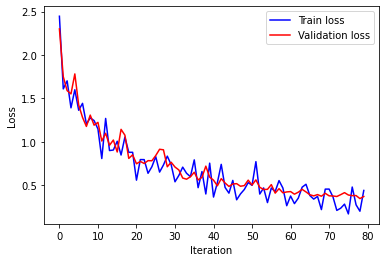

In [27]:
evaluate(model)

plt.plot(train_losses, 'b')
plt.plot(valid_losses, 'r')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'])
plt.show()